### Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from google.cloud import storage
from io import BytesIO

#### Variables

In [2]:
#train_test_split
random_stat = 42

SIZE = 416

#in case we don't want to use all images, to simplify the process
images0 = 0
images1 = 10000

#### Paths

In [3]:
RAW_DATA_PATH = '/home/jupyter/raw_data/'
DATA_PATH = '/home/jupyter/data/'

FRAME_PATH = os.path.join(os.getcwd(), 'images')  # .jpg
MASK_PATH = os.path.join(os.getcwd(), 'labels')  # .txt
METADATA_PATH = os.path.join(os.getcwd(), 'metadata') # .txt

# YOLOv3 config file directory
CONFIG_PATH = os.path.join(os.getcwd(), 'cfg')

# YOLOv3 training weights will be saved here
BACKUP_PATH = os.path.join(os.getcwd(), 'backup')

DATA_EXTENSION_FILE_PATH = os.path.join(CONFIG_PATH, 'ih_fp.data')


In [4]:
image_annots = pd.read_csv('data/image_annots.csv')
image_annots = image_annots [images0:images1]

In [5]:
image_annots.head()

,ImageID,OriginalURL,Size
0,25e3acb1a25707dd,c6.staticflickr.com/8/7659/17891339551_6ae11be...,0.341452
1,9aaa4a4bce049a85,farm6.staticflickr.com/8164/7388947910_8ea3aa9...,0.749160
2,6db5e012cf2936fa,c3.staticflickr.com/3/2874/9062318686_f4917058...,0.594201
3,9172175c072967ae,c7.staticflickr.com/1/64/214333364_5dd9c7ece5_...,0.683036
4,02bca0d3d5b73d77,farm8.staticflickr.com/3661/3555577527_217e372...,0.279661


Separate data into train validation and test

In [7]:
def write_train_list(METADATA_PATH, FRAME_PATH, name, series):
    list_fp = os.path.join(METADATA_PATH, name)

    with open(list_fp, "w") as f:
        for image_id in series:
            line = "{}\n".format(os.path.join(FRAME_PATH, "{}.jpg".format(image_id)))
            f.write(line)

In [8]:
tr_series, val_test_series = train_test_split(image_annots['ImageID'], test_size=0.2, random_state=random_stat)
test_series, val_series = train_test_split(val_test_series, test_size=0.5, random_state=random_stat)

print(f'The # of train set: {tr_series.shape[0]}, The # of validation set: {val_series.shape[0]} \
The # of test set: {test_series.shape[0]}')

# train image path list
write_train_list(METADATA_PATH, FRAME_PATH, "tr_list.txt", tr_series)
# validation image path list
write_train_list(METADATA_PATH, FRAME_PATH, "val_list.txt", val_series)
# test image path list
write_train_list(METADATA_PATH, FRAME_PATH, "test_list.txt", test_series)

The # of train set: 6248, The # of validation set: 781 The # of test set: 781


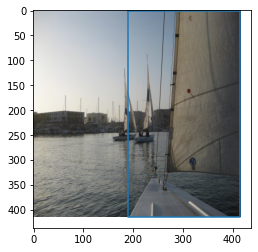

In [9]:
dim = (SIZE,SIZE)
ex_image_id = image_annots.ImageID.values[80]
ex_img_path = os.path.join(FRAME_PATH, "{}.jpg".format(ex_image_id))
ex_label_path = os.path.join(MASK_PATH, "{}.txt".format(ex_image_id))

plt.imshow(cv2.cvtColor(cv2.imread(ex_img_path),cv2.COLOR_BGR2RGB))
    
with open(ex_label_path, "r") as f:
    for line in f:
        x = line.strip().split()
        class_name  = x[0]
        rcx, rcy, rw, rh = [float(i) for i in x[1:]]
        x = (rcx-rw/2)*dim[0]
        y = (rcy-rh/2)*dim[1]
        w = rw*dim[0]
        h = rh*dim[1]
        plt.plot([x, x, x+w, x+w, x], [y, y+h, y+h, y, y])